In [51]:
import re
import os
import time
import numpy as np
import pandas as pd 
import unicodedata
import tensorflow as tf
import tensorflow.keras as krs
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
import csv

BUFFER_SIZE = 20000
BATCH_SIZE = 64
embedding_dim = 50 # first it was 200

In [52]:
data_unprocessed_news = pd.read_excel('data.xlsx')
data_unprocessed_news.head()

,Headline,Short,Source,Time,Publish Date
0,4 ex-bank officials booked for cheating bank o...,The CBI on Saturday booked four former officia...,The New Indian Express,09:25:00,2017-03-26
1,Supreme Court to go paperless in 6 months: CJI,Chief Justice JS Khehar has said the Supreme C...,Outlook,22:18:00,2017-03-25
2,"At least 3 killed, 30 injured in blast in Sylh...","At least three people were killed, including a...",Hindustan Times,23:39:00,2017-03-25
3,Why has Reliance been barred from trading in f...,Mukesh Ambani-led Reliance Industries (RIL) wa...,Livemint,23:08:00,2017-03-25
4,Was stopped from entering my own studio at Tim...,TV news anchor Arnab Goswami has said he was t...,YouTube,23:24:00,2017-03-25


In [53]:
from sklearn.utils import shuffle
# shuffling the data 
data_unprocessed_news = shuffle(data_unprocessed_news)
data_unprocessed_news.head()

,Headline,Short,Source,Time,Publish Date
25348,Parrikar gives credit to RSS teachings for sur...,Defence Minister Manohar Parrikar on Monday at...,PTI,00:00:00,2016-10-18
17186,Doll making centre helps women earn livelihood...,"A doll making centre, established by a German ...",YouTube,19:57:00,2016-12-05
7363,India defeat New Zealand 3-1 to progress to Da...,Twenty-two-year-old Indian tennis player Ramku...,Twitter,19:55:00,2017-02-05
17003,"₹2,000 crore undisclosed income admitted since...",The Finance Ministry on Tuesday said that appr...,PIB,18:32:00,2016-12-06
8275,Sachin says he changed playing style after wai...,Sachin Tendulkar has revealed he used a waiter...,India Today,17:37:00,2017-01-30


In [55]:
summaries, longreview = pd.DataFrame(), pd.DataFrame()
summaries['short'] = data_unprocessed_news['Short']#[:data_to_use]
longreview['long'] = data_unprocessed_news['Headline']#[:data_to_use]
(summaries.shape,longreview.shape)

((55104, 1), (55104, 1))

In [56]:
def clean_words(sentence):
    sentence = str(sentence).lower()
    sentence = unicodedata.normalize('NFKD', sentence).encode('ascii', 'ignore').decode('utf-8', 'ignore') # for converting é to e and other accented chars
    sentence = re.sub(r"http\S+","",sentence)
    sentence = re.sub(r"there's", "there is", sentence)
    sentence = re.sub(r"i'm", "i am", sentence)
    sentence = re.sub(r"he's", "he is", sentence)
    sentence = re.sub(r"she's", "she is", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"that's", "that is", sentence)
    sentence = re.sub(r"what's", "that is", sentence)
    sentence = re.sub(r"where's", "where is", sentence)
    sentence = re.sub(r"how's", "how is", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can't", "cannot", sentence)
    sentence = re.sub(r"n't", " not", sentence)
    sentence = re.sub(r"n'", "ng", sentence)
    sentence = re.sub(r"'bout", "about", sentence)
    sentence = re.sub(r"'til", "until", sentence)
    sentence = re.sub(r"\"", "", sentence)
    sentence = re.sub(r"\'", "", sentence)
    sentence = re.sub(r' s ', "",sentence)
    sentence = re.sub(r"&39", "", sentence) # the inshorts data has this in it
    sentence = re.sub(r"&34", "", sentence) # the inshorts data has this in it
    sentence = re.sub(r"[\[\]\\0-9()\"$#%/@;:<>{}`+=~|.!?,-]", "", sentence)
    sentence = re.sub(r"&", "", sentence)
    sentence = re.sub(r"\\n", "", sentence)
    sentence = sentence.strip()
    return sentence

In [57]:
summaries['short'] = summaries['short'].apply(lambda x: clean_words(x))
longreview['long'] = longreview['long'].apply(lambda x: clean_words(x))

In [58]:
longreview.head()

,long
25348,parrikar gives credit to rss teachings for sur...
17186,doll making centre helps women earn livelihood...
7363,india defeat new zealand to progress to davis...
17003,crore undisclosed income admitted since note ban
8275,sachin says he changed playing style after wai...


In [59]:
# adding start and end token to the senteces of label 
start_token, end_token = '<startseq>' , '<endseq>'
summaries = summaries.apply(lambda x: start_token + ' ' + x + ' ' + end_token)
summaries.head()

,short
25348,<startseq> defence minister manohar parrikar o...
17186,<startseq> a doll making centre established by...
7363,<startseq> twentytwoyearold indian tennis play...
17003,<startseq> the finance ministry on tuesday sai...
8275,<startseq> sachin tendulkar has revealed he us...


In [60]:
val_split = 0.1
# train validation split
summaries_train = summaries[int(len(summaries)*val_split):]
summaries_val = summaries[:int(len(summaries)*val_split)]
longreview_train = longreview[int(len(summaries)*val_split):]
longreview_val = longreview[:int(len(summaries)*val_split)]

len(longreview_val),len(longreview_train)

(5510, 49594)

In [61]:
longreview_train.iloc[0], summaries_train.iloc[0]

(long    mastermind hafiz saeed under house arrest in p...
 Name: 8227, dtype: object,
 short    <startseq> mumbai terror attack mastermind and...
 Name: 8227, dtype: object)

In [63]:
# because there are senteces with unusually long lengths, 
# we caculate the max length that 95% of sentences are shorter than that
def max_length(shorts, longs, prct):
    # Create a list of all the captions
    
    length_longs = list(len(d.split()) for d in longs)
    length_shorts = list(len(d.split()) for d in shorts)

    print('percentile {} of length of news: {}'.format(prct,np.percentile(length_longs, prct)))
    print('longest sentence: ', max(length_longs))
    print()
    print('percentile {} of length of summaries: {}'.format(prct,np.percentile(length_shorts, prct)))
    print('longest sentence: ', max(length_shorts))
    print()
    return int(np.percentile(length_longs, prct)),int(np.percentile(length_shorts, prct))

# selecting sentence length based on the percentile of data that fits in the length
max_len_news, max_len_summary= max_length(summaries_train['short'].to_list(), longreview_train['long'].to_list(), 90)


print('max-length longreview chosen for training: ', max_len_news)
print('max-length summaries chosen for training: ', max_len_summary)

percentile 90 of length of news: 10.0
longest sentence:  14

percentile 90 of length of summaries: 62.0
longest sentence:  68

max-length longreview chosen for training:  10
max-length summaries chosen for training:  62


In [64]:
# making a vocabulary of the words 
def create_vocab(shorts, longs = None, minimum_repeat = 3):

    # Create a list of all the captions
    all_captions = []
    for s in shorts:
        all_captions.append(s)

    # Consider only words which occur at least minimum_occurrence times in the corpus
    word_counts = {}
    nsents = 0
    for sent in all_captions:
        nsents += 1
        for w in sent.split(' '):
            word_counts[w] = word_counts.get(w, 0) + 1

    vocab = [w for w in word_counts if word_counts[w] >= minimum_repeat]
    
    vocab = list(set(vocab))
    return vocab

In [66]:
# each word in the vocabulary must be used in the data atleast minimum_repeat times
vocab_dec = create_vocab(summaries_train['short'].to_list(), minimum_repeat=5) # here we just use the words in vocabulary of summaries
# removing one character words from vocab except for 'a'
for v in vocab_dec:
    if len(v) == 1 and v!='a' and v!='i':
        vocab_dec.remove(v) 
        
vocab_dec = sorted(vocab_dec)[1:] # [1:] is for the '' 
vocab_dec[:10]

['<endseq>',
 '<startseq>',
 'a',
 'aa',
 'aadhaar',
 'aadhaarbased',
 'aadmi',
 'aai',
 'aaj',
 'aakash']

In [67]:
# each word in the vocabulary must be used in the data atleast minimum_repeat times
vocab_enc = create_vocab(longreview_train['long'].to_list(), minimum_repeat=3) # here we just use the words in vocabulary of summaries
# removing one character words from vocab except for 'a'
for v in vocab_enc:
    if len(v) == 1 and v!='a' and v!='i':
        vocab_enc.remove(v) 
        
vocab_enc = sorted(vocab_enc)[1:] # [1:] is for the '' 
vocab_enc[:10]

['a',
 'aa',
 'aadhaar',
 'aadhaarbased',
 'aadmi',
 'aai',
 'aaj',
 'aakash',
 'aam',
 'aamir']

In [68]:
oov_token = '<UNK>'
filters = '!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n' # making sure all the last non digit non alphabet chars are removed
document_tokenizer = krs.preprocessing.text.Tokenizer(filters = filters,oov_token=oov_token)
summary_tokenizer = krs.preprocessing.text.Tokenizer(filters = filters,oov_token=oov_token)
document_tokenizer.fit_on_texts(vocab_enc)
summary_tokenizer.fit_on_texts(vocab_dec)#summaries_train['short'])

# caculating number of words in vocabulary of encoder and decoder
# they are important for positional encoding
encoder_vocab_size = len(document_tokenizer.word_index) + 1 
decoder_vocab_size = len(summary_tokenizer.word_index) + 1

# vocab_size
encoder_vocab_size, decoder_vocab_size

(12568, 23605)

In [69]:
ixtoword_enc = {} # index to word dic
ixtoword_dec = {} # index to word dic

wordtoix_enc = document_tokenizer.word_index # word to index dic
ixtoword_enc[0] = '<PAD0>' # no word in vocab has index 0. but padding is indicated with 0
ixtoword_dec[0] = '<PAD0>' # no word in vocab has index 0. but padding is indicated with 0

for w in document_tokenizer.word_index:
    ixtoword_enc[document_tokenizer.word_index[w]] = w
################################################
wordtoix_dec = summary_tokenizer.word_index # word to index dic

for w in summary_tokenizer.word_index:
    ixtoword_dec[summary_tokenizer.word_index[w]] = w

In [70]:
# assign a number to each word inorder to find it in word embeddings
inputs = document_tokenizer.texts_to_sequences(longreview_train['long'])
targets = summary_tokenizer.texts_to_sequences(summaries_train['short'])
inputs_val = document_tokenizer.texts_to_sequences(longreview_val['long'])
targets_val = summary_tokenizer.texts_to_sequences(summaries_val['short'])

In [71]:
inputs = krs.preprocessing.sequence.pad_sequences(inputs, maxlen=max_len_news, padding='post', truncating='post')
targets = krs.preprocessing.sequence.pad_sequences(targets, maxlen=max_len_summary, padding='post', truncating='post')
inputs_val = krs.preprocessing.sequence.pad_sequences(inputs_val, maxlen=max_len_news, padding='post', truncating='post')
targets_val = krs.preprocessing.sequence.pad_sequences(targets_val, maxlen=max_len_summary, padding='post', truncating='post')

In [72]:
# validate train split
dataset = tf.data.Dataset.from_tensor_slices((inputs,targets)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset_val = tf.data.Dataset.from_tensor_slices((inputs_val,targets_val)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE*2)

In [73]:
longreview_val.reset_index(inplace=True, drop=True)
summaries_val.reset_index(inplace=True, drop=True)
longreview_train.reset_index(inplace=True, drop=True)
summaries_train.reset_index(inplace=True, drop=True)

In [74]:
import matplotlib.pyplot as plt

def hist(history):
    plt.title('Loss')

    x= [i[0] for i in history['val']]
    y=[i[1] for i in history['val']]
    plt.plot(x,y,'x-')
    
    x= [i[0] for i in history['train']]
    y=[i[1] for i in history['train']]    
    plt.plot(x,y,'o-')

    plt.legend(['validation','train'])
    plt.show()
    print('smallest val loss:', sorted(history['val'],key=lambda x: x[1])[0])

In [75]:
# the job of this function is to calculate the above equation
def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)

    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    output = tf.matmul(attention_weights, v)
    return output, attention_weights

In [76]:
class MultiHeadAttention(krs.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads # The dimensions of Q, K, V are called depth

        # the input of these 3 layers are the same: X
        self.wq = krs.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
        self.wk = krs.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
        self.wv = krs.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))

        self.dense = tf.keras.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
    
    # reshape the Q,K,V 
    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        # learn the Q,K,V matrices (the layers' weightes)
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        # reshape them
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        
        # the last dens layer expect one vector so we use concat
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
            
        return output, attention_weights

In [77]:
def get_angles(position, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return position * angle_rates

# The dimension of positional encodings is the same as
# the embeddings (d_model) for facilitating the summation of both.
def positional_encoding(position, d_model):
    angle_rads = get_angles(
        np.arange(position)[:, np.newaxis],
        np.arange(d_model)[np.newaxis, :],
        d_model
    )

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

In [79]:
 # Making the embedding mtrix
def make_embedding_layer(vocab_len, wordtoix, embedding_dim=200, glove=True, glove_path= '../glove'):
    if glove == False:
        print('Just a zero matrix loaded')
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # just a zero matrix 
    else:
        print('Loading glove...')
        glove_dir = glove_path
        embeddings_index = {} 
        f = open(os.path.join('./glove.6B.50d.txt'), encoding="utf-8")
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        f.close()
        # Get n-dim dense vector for each of the vocab_rocc
        embedding_matrix = np.zeros((vocab_len, embedding_dim)) # to import as weights for Keras Embedding layer
        for word, i in wordtoix.items():
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                # Words not found in the embedding index will be all zeros
                embedding_matrix[i] = embedding_vector
        
        print("GloVe ",embedding_dim, ' loaded!')

    embedding_layer = Embedding(vocab_len, embedding_dim, mask_zero=True, trainable=False) # we have a limited vocab so we 
                                                                                           # do not train the embedding layer
                                                                                           # we use 0 as padding so => mask_zero=True
    embedding_layer.build((None,))
    embedding_layer.set_weights([embedding_matrix])
    return embedding_layer

embeddings_encoder = make_embedding_layer(encoder_vocab_size, wordtoix_enc, embedding_dim=embedding_dim, glove=True)
embeddings_decoder = make_embedding_layer(decoder_vocab_size, wordtoix_dec, embedding_dim=embedding_dim, glove=True)


Loading glove...
GloVe  50  loaded!
Loading glove...
GloVe  50  loaded!


In [80]:
# hyper-params
init_lr = 1e-3
lmbda_l2 = 0.1
d_out_rate = 0.1 # tested 0.4, 0.3, 0.1 values this 0.1 seems to be the best
num_layers = 4 # chaged from 4 to 5 to learn better
d_model = embedding_dim # d_model is the representation dimension or embedding dimension of a word (usually in the range 128–512)
dff = 512 # number of neurons in feed forward network
num_heads = 5 # first it was 8 i chenged it to 10 to use embd =300d

In [81]:
# The Point-wise feed-forward network block is essentially a 
# two-layer linear transformation which is used identically throughout the model
def point_wise_feed_forward_network(d_model, dff):
    return krs.Sequential([
        krs.layers.Dense(dff, activation='relu',kernel_regularizer=krs.regularizers.l2(l=lmbda_l2)),
        krs.layers.Dense(d_model,kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
    ])

In [82]:
class EncoderLayer(krs.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=d_out_rate):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = krs.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = krs.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = krs.layers.Dropout(rate)
        self.dropout2 = krs.layers.Dropout(rate)
   
    # it has 1 layer of multi-headed attention
    def call(self, x, training, mask):
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [83]:
class DecoderLayer(krs.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=d_out_rate):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = krs.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = krs.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = krs.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = krs.layers.Dropout(rate)
        self.dropout2 = krs.layers.Dropout(rate)
        self.dropout3 = krs.layers.Dropout(rate)
    
    # it has 2 layers of multi-headed attention
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

In [84]:
class Encoder(krs.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, maximum_position_encoding, rate=d_out_rate):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = embeddings_encoder
        self.pos_encoding = positional_encoding(maximum_position_encoding, self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]

        self.dropout = krs.layers.Dropout(rate)
        self.dropout_embd = krs.layers.Dropout(rate)
        
    def call(self, x, training, mask):
        seq_len = tf.shape(x)[1]

        x = self.embedding(x)
        x = self.dropout_embd(x, training=training) # dropout added to encoder input changed from nothing to this
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)
    
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
    
        return x

In [85]:
class Decoder(krs.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, maximum_position_encoding, rate=d_out_rate):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = embeddings_decoder
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)] # a list of decoder layers
        self.dropout = krs.layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask) # enc_output is fed into it

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
        return x, attention_weights

In [86]:
class Transformer(krs.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                                     target_vocab_size, pe_input, pe_target, rate=d_out_rate):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size, pe_input, rate)

        self.decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size, pe_target, rate)

        self.final_layer = krs.layers.Dense(target_vocab_size, kernel_regularizer=krs.regularizers.l2(l=lmbda_l2))
        
        
    # training argument is used in dropout inputs
    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encoder(inp, training, enc_padding_mask)
       
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

In [87]:
transformer = Transformer(
    num_layers, 
    d_model, 
    num_heads, 
    dff,
    encoder_vocab_size, 
    decoder_vocab_size, 
    pe_input=max_len_news,
    pe_target=max_len_summary,
)

In [88]:
# Padding mask for masking "pad" sequences so 
# they won't affect the loss
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

# Lookahead mask for masking future words from
# contributing in prediction of current words in self attention
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

In [89]:
# this function is use in training step
def create_masks(inp, tar):
    enc_padding_mask = create_padding_mask(inp)
    dec_padding_mask = create_padding_mask(inp)

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
        
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
    return enc_padding_mask, combined_mask, dec_padding_mask

In [90]:
lr_schedule = krs.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=init_lr, # originally was 1e-5
    decay_steps=4000, # approximately 5 epochs
    decay_rate=0.95) # originally was 0.9

In [91]:
optimizer2 = Adam(lr_schedule , beta_1=0.9, beta_2=0.98, epsilon=1e-9) # changed to init
loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='none')

In [92]:
def loss_function(real, pred, l2= False):
 
    if l2:
        lambda_ = 0.0001
        l2_norms = [tf.nn.l2_loss(v) for v in transformer.trainable_variables]
        l2_norm = tf.reduce_sum(l2_norms)
        l2_value = lambda_ * l2_norm
        loss_ = loss_object(real, pred) + l2_value
    else:
        loss_ = loss_object(real, pred) 
    
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [93]:
checkpoint_path4 ="./checkpoints4"

ckpt4 = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer2)

ckpt_manager4 = tf.train.CheckpointManager(ckpt4, checkpoint_path4, max_to_keep=100)

# if ckpt_manager4.latest_checkpoint:
#     ckpt4.restore(ckpt_manager4.latest_checkpoint)
#     print ('Latest checkpoint restored!!')

In [94]:
def evaluate(input_document):
    input_document = document_tokenizer.texts_to_sequences([input_document])
    input_document = krs.preprocessing.sequence.pad_sequences(input_document, maxlen=max_len_news, 
                                                                           padding='post', truncating='post')
    
    encoder_input = tf.expand_dims(input_document[0], 0)

    decoder_input = [summary_tokenizer.word_index[start_token]]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(max_len_summary):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input, 
            output,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        # stop prediciting if it reached end_token
        if predicted_id == summary_tokenizer.word_index[end_token]:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)
    return tf.squeeze(output, axis=0), attention_weights

def summarize(input_document):
    # not considering attention weights for now, can be used to plot attention heatmaps in the future
    summarized = evaluate(input_document=input_document)[0].numpy()
    summarized = np.expand_dims(summarized[1:], 0)  # remove start_token
    return summary_tokenizer.sequences_to_texts(summarized)[0]  # since the

In [95]:
def validate():
    print('validation started ...')
    val_loss.reset_states()
    for (batch, (inp, tar)) in enumerate(dataset_val):    
        tar_inp = tar[:, :-1] # <startseq> hi im moein
        tar_real = tar[:, 1:] # hi im moein <endseq>

        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

        # Operations are recorded if they are executed within this context manager
        # and at least one of their inputs is being "watched". Trainable variables are automatically watched
        predictions, _ = transformer(
            inp, tar_inp, 
            False, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)
        val_loss(loss)
    print('\n* Validation loss: {} '.format(val_loss.result()) )
    return val_loss.result()
# validate()

In [96]:
@tf.function # Compiles a function into a callable TensorFlow graph
def train_step(inp, tar):
    tar_inp = tar[:, :-1] # <startseq> hi im moein
    tar_real = tar[:, 1:] # hi im moein <endseq>

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    
    # Operations are recorded if they are executed within this context manager
    # and at least one of their inputs is being "watched". Trainable variables are automatically watched
    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp, 
            True, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer2.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    # mean the loss with new computed  loss of the step
    train_loss(loss)

In [97]:
history={'val':[],'train':[]}
EPOCHS = 300
not_progressing = 0
# Computes the (weighted) mean of the given loss values.
train_loss = krs.metrics.Mean(name='train_loss')
val_loss = krs.metrics.Mean(name='val_loss')

In [98]:
params = {
'lmbda_l2' : lmbda_l2,
'd_out_rate' :d_out_rate,
'num_layers' : num_layers ,
'd_model' : d_model  ,
'dff' : dff ,
'num_heads' : num_heads,
'init_lr':init_lr}
params

{'lmbda_l2': 0.1,
 'd_out_rate': 0.1,
 'num_layers': 4,
 'd_model': 50,
 'dff': 512,
 'num_heads': 5,
 'init_lr': 0.001}

In [99]:
ep = 1
best_val_loss = np.inf
i1,i2,i3,i4 = np.random.randint(len(summaries_val)),np.random.randint(len(summaries_val)),np.random.randint(len(summaries_val)),np.random.randint(len(summaries_val))

{'lmbda_l2': 0.1, 'd_out_rate': 0.1, 'num_layers': 4, 'd_model': 50, 'dff': 512, 'num_heads': 5, 'init_lr': 0.001}
########################################
Epoch 1 Batch 0 Loss 6.0844
Epoch 1 Batch 150 Loss 5.9796
Epoch 1 Batch 300 Loss 5.9269
Epoch 1 Batch 450 Loss 5.8831
Epoch 1 Batch 600 Loss 5.8431
Epoch 1 Batch 750 Loss 5.8114

the worlds largest <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> has been released the worlds largest <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>
the supreme court on wednesday said that the government has been killed by the government to the government to the government to the government to the government to the government the government to the government the government the government has been imposed the government to the government to the government the government the gov

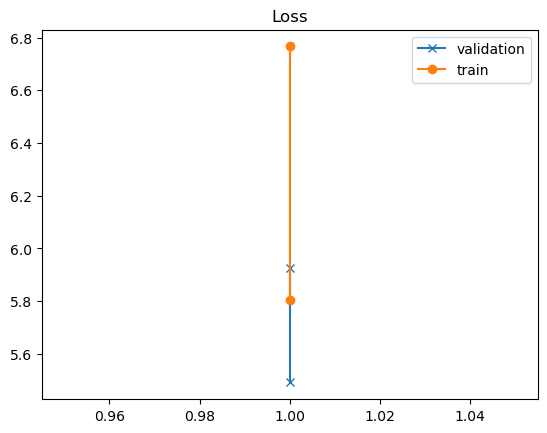

smallest val loss: (1, 5.491483)

Time taken for this epoch: 1580.60 secs

Epoch 2 Batch 0 Loss 5.5374
Epoch 2 Batch 150 Loss 5.5779
Epoch 2 Batch 300 Loss 5.5570
Epoch 2 Batch 450 Loss 5.5356
Epoch 2 Batch 600 Loss 5.5182
Epoch 2 Batch 750 Loss 5.5013

the new trailer of the new york has been released a new version of the <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> and <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> and <UNK>
the us government has said that the government will be able to be able to the government to be able to the government the government the government said the government has been imposed by the government to be imposed by the government and the government will be imposed by the government to be imposed
a video of the video of the video of the video of the video of the video of the video of the video shows the video shows the video shows the vi

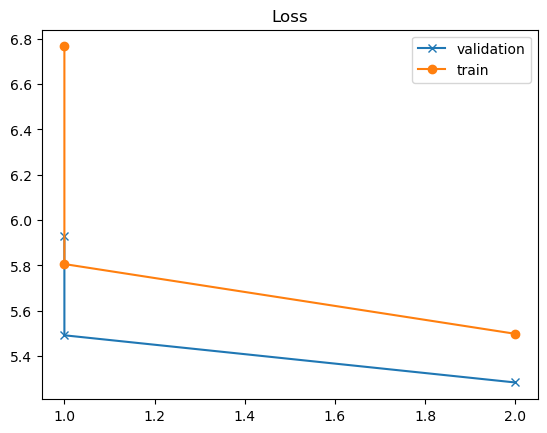

smallest val loss: (2, 5.2832193)

Time taken for this epoch: 1510.37 secs

Epoch 3 Batch 0 Loss 5.3731
Epoch 3 Batch 150 Loss 5.3641
Epoch 3 Batch 300 Loss 5.3508
Epoch 3 Batch 450 Loss 5.3413
Epoch 3 Batch 600 Loss 5.3322
Epoch 3 Batch 750 Loss 5.3234

the trailer of the new york has been released on the first version of the <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> and <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> and <UNK> <UNK> <UNK> <UNK> <UNK> and <UNK> <UNK> <UNK> <UNK> and <UNK>
the indian government has said that the government is not not not not to be able to be able to be able to be able to be able to be able to the us to be able to be able to be able to the us to be able to be able to be able to the us
a new yorkbased startup has created a <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <

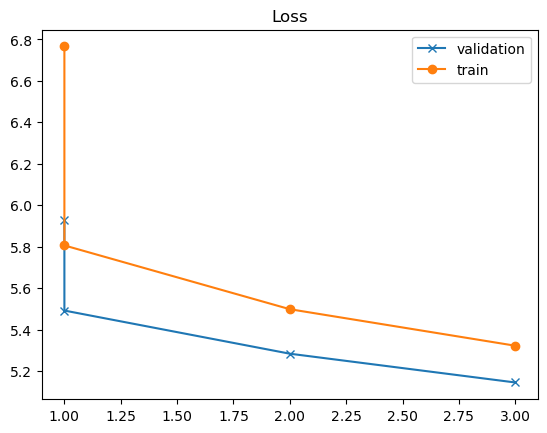

smallest val loss: (3, 5.1443443)

Time taken for this epoch: 1521.19 secs

Epoch 4 Batch 0 Loss 5.2453
Epoch 4 Batch 150 Loss 5.2206
Epoch 4 Batch 300 Loss 5.2243
Epoch 4 Batch 450 Loss 5.2189
Epoch 4 Batch 600 Loss 5.2145
Epoch 4 Batch 750 Loss 5.2101

the first edition of the upcoming film series the upcoming film will be released on march the film will be released on march the film will be released on march the film will be released on march the film will be released on march
the indian express india has been arrested in the country in the country of the country and the country the country has been arrested by the police said that the police have been arrested in the country and the police said that the police have been arrested in the police said that the police have been arrested in the attack
a yearold video shows the video shows the video shows the video shows the video shows the video shows the video shows the video shows the video shows the video features a <UNK> <UNK> <UNK> 

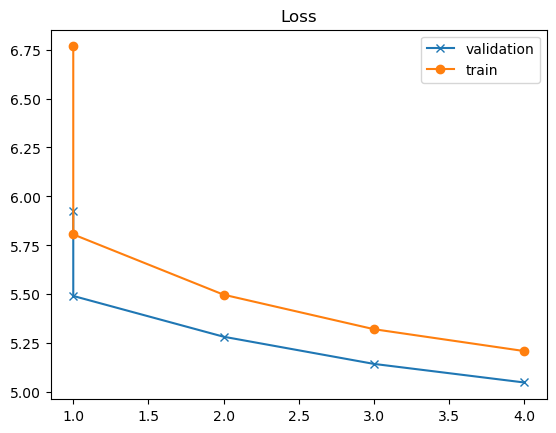

smallest val loss: (4, 5.049407)

Time taken for this epoch: 1543.69 secs

Epoch 5 Batch 0 Loss 5.1361
Epoch 5 Batch 150 Loss 5.1392
Epoch 5 Batch 300 Loss 5.1364
Epoch 5 Batch 450 Loss 5.1339
Epoch 5 Batch 600 Loss 5.1345
Epoch 5 Batch 750 Loss 5.1338

the first edition of the <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> and <UNK>
the us government has said that the government has been arrested in the country that the government has been arrested in the country the country the government has been arrested in the country the country the government said the government has been arrested in the state bank of the state bank of the government officials said
a yearold video explores a <UNK> video of the video shows the video shows the video shows 

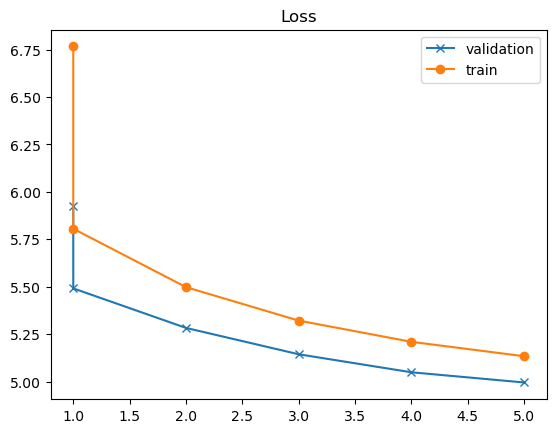

smallest val loss: (5, 4.9957356)

Time taken for this epoch: 1522.95 secs

Epoch 6 Batch 0 Loss 5.1117
Epoch 6 Batch 150 Loss 5.0806


KeyboardInterrupt: 

In [101]:
print(params)
print('#'*40)

for epoch in range(ep,EPOCHS+1):
    ep = epoch
    start = time.time()

    train_loss.reset_states()
  
    for (batch, (inp, tar)) in enumerate(dataset):
        
        train_step(inp, tar)
    
        if batch % 150 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(epoch , batch, train_loss.result()))
                  
    print()
    print(summarize(clean_words(longreview_val['long'][i1])))
    print(summarize(clean_words(longreview_val['long'][i2])))
    print(summarize(clean_words(longreview_val['long'][i3])))
    print(summarize(clean_words(longreview_val['long'][i4])))
    print()
    
    val_loss_ = validate().numpy()
    history['val'].append((epoch,val_loss_))
    print ('\n* Train Loss {:.4f}'.format(train_loss.result()))
    history['train'].append((epoch,train_loss.result().numpy()))
    
    
    if best_val_loss-val_loss_ > 0.1:
        ckpt_save_path4 = ckpt_manager4.save()
        print ('\nSaving checkpoint for epoch {} at {}'.format(epoch, ckpt_save_path4))  
        best_val_loss = val_loss_
    
    hist(history)
    #print('Current Lr: ',optimizer2._decayed_lr('float32').numpy())
    print ('\nTime taken for this epoch: {:.2f} secs\n'.format(time.time() - start))
    print('='*40)

In [ ]:
print(clean_words(longreview_val['long'][i2]))
print()
print(summarize(clean_words(longreview_val['long'][i2])))